# Minimum Spanning Trees

## Tools for Experiments and Drawing

We use again the `networkx` package for representing and drawing graphs.

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from networkx.drawing.layout import spring_layout
import networkx as nx

For Kruskal's algorithm, we will need a union-find data structure, so we add the implementation (from other notebook).

In [19]:
class UnionFind: # Ranked quick-union with path compression
    def __init__(self, no_nodes):
        self.parent = list(range(no_nodes))
        self.components = no_nodes
        self.rank = [0] * no_nodes  # [0, ..., 0]

    def find(self, v):
        if self.parent[v] == v:
            return v
        root = self.find(self.parent[v])
        self.parent[v] = root
        return root

    def union(self, v, w):
        repr_v = self.find(v)
        repr_w = self.find(w)
        if repr_v == repr_w:
            return
        if self.rank[repr_w] < self.rank[repr_v]:
            self.parent[repr_w] = repr_v
        else:
            self.parent[repr_v] = repr_w
            if self.rank[repr_v] == self.rank[repr_w]:
                self.rank[repr_w] += 1
        self.components -= 1

    def connected(self, v, w):
        return self.find(v) == self.find(w)

    def count(self):
        return self.components

We create a random example graph. In the notebook, we use the standard API of networkx graphs.

With the alternative edge representation from the slides, the algorithms also support multi graphs (with parallel edges).
Also networkx has a suitable class `MultiGraph`, but drawing parallel edges in the notebook is somewhat complicated, so we do not support them.

In [12]:
import random
from itertools import combinations

def create_random_weighted_graph(no_nodes, no_edges, 
                                 min_edge_weight, max_edge_weight):
    graph = nx.Graph()
    node_numbers = list(range(no_nodes))
    graph.add_nodes_from(node_numbers)
    all_pairs = list(combinations(node_numbers, 2))
    possible_weights = list(range(min_edge_weight, max_edge_weight + 1))
    # print(all_pairs)
    for n1, n2 in random.sample(all_pairs, no_edges):
        weight = random.choice(possible_weights)
        graph.add_edge(n1, n2, weight=weight)
    return graph
        
graph = create_random_weighted_graph(10, 18, 1, 30)


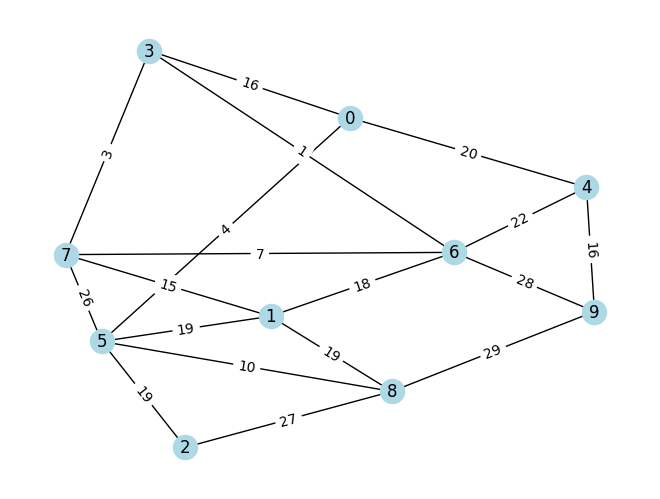

In [14]:
pos = spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_size=300, node_color='lightblue')
edge_labels = dict([((u,v,),d['weight']) for u,v,d in graph.edges(data=True)])
_ = nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

 ## Kruskal's Algorithm

Kruskal's algorithm considers the edges in increasing order of their weight and decides whether they should be included in the spanning tree or be discarded. We can terminate as soon as we have connected all nodes, which is the case if the tree contains #nodes-1 edges.

In [15]:
import heapq

class MSTKruskal:
    def __init__(self, graph):
        self.included_edges = []
        self.total_weight = 0
        candidates = []
        # add all edges to priority queue
        for u, v, weight in graph.edges.data('weight'):
            heapq.heappush(candidates, (weight, u, v))
        uf = UnionFind(graph.number_of_nodes())

        while (candidates and
               len(self.included_edges) < graph.number_of_nodes() - 1):
            weight, u, v = heapq.heappop(candidates)
            if uf.connected(u, v):
                print("discarded edge", (u,v), "with weight", weight)
                continue
            uf.union(u, v)
            self.included_edges.append((u,v))
            print("added edge", (u,v), "with weight", weight)
            self.dump()
            self.total_weight += weight

    def edges(self):
        for e in self.included_edges:
            yield e

    def weight(self):
        return self.total_weight
    
    def dump(self):
        nx.draw(graph, pos, with_labels=True, node_size=300, node_color='lightblue', edge_color="gray")
        edge_labels=dict([((u,v,),d['weight']) for u,v,d in graph.edges(data=True)])
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
        nx.draw_networkx_edges(graph, pos, edgelist=self.included_edges, edge_color="r")
        plt.show()

added edge (3, 6) with weight 1


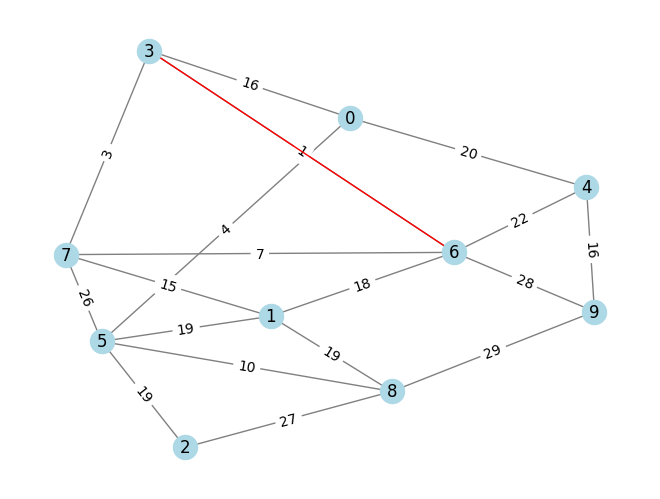

added edge (3, 7) with weight 3


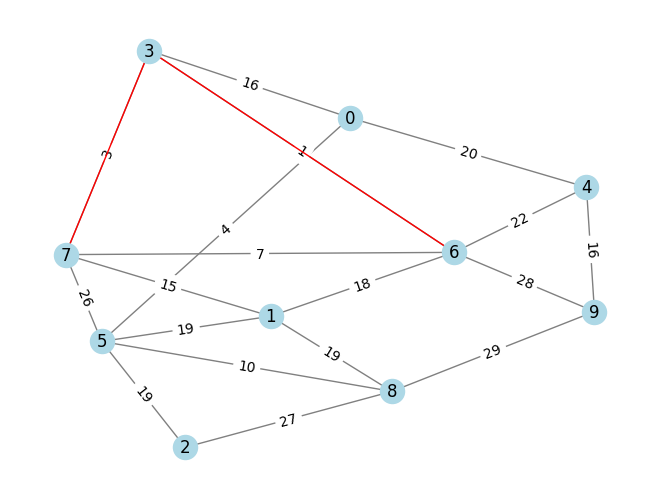

added edge (0, 5) with weight 4


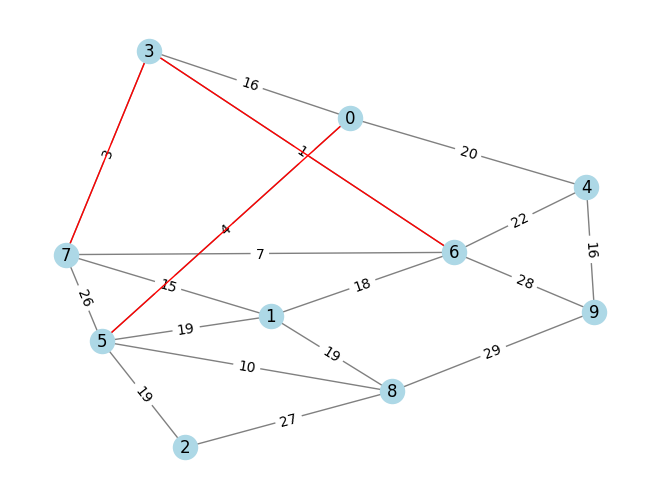

discarded edge (6, 7) with weight 7
added edge (5, 8) with weight 10


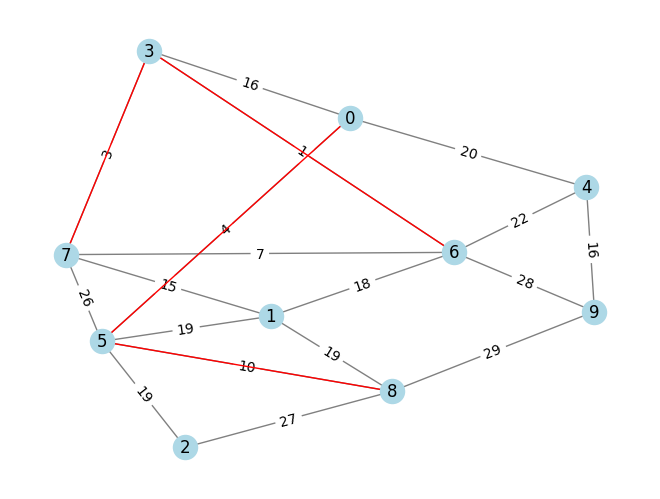

added edge (1, 7) with weight 15


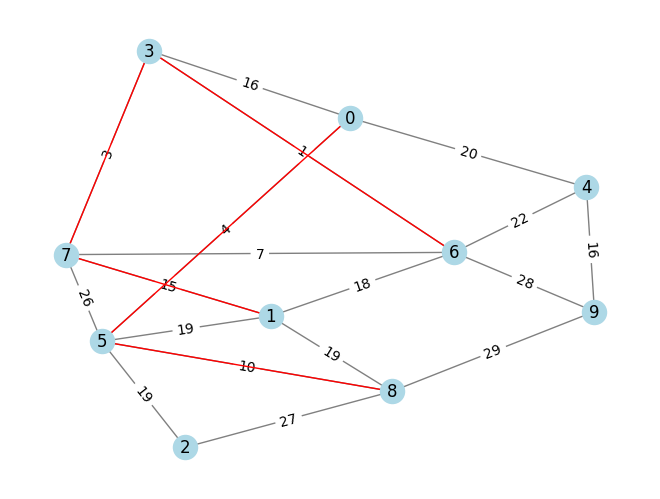

added edge (0, 3) with weight 16


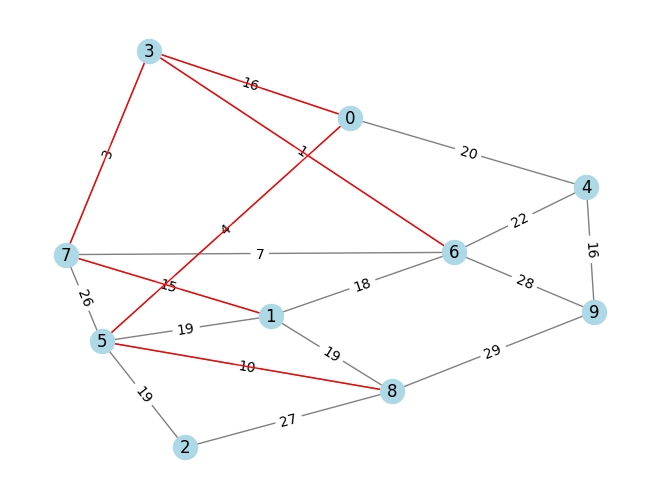

added edge (4, 9) with weight 16


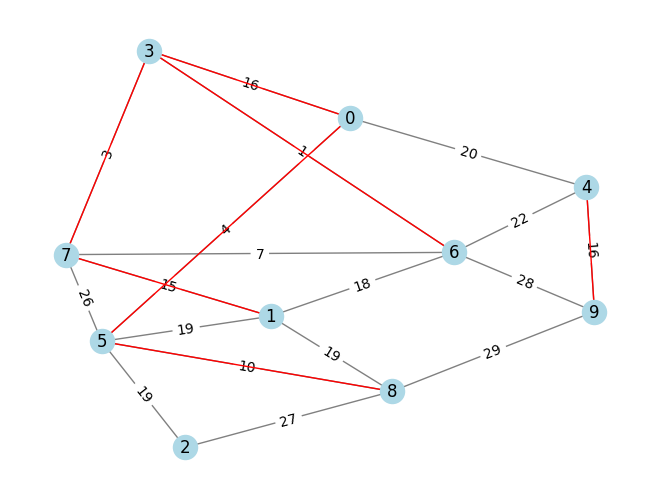

discarded edge (1, 6) with weight 18
discarded edge (1, 5) with weight 19
discarded edge (1, 8) with weight 19
added edge (2, 5) with weight 19


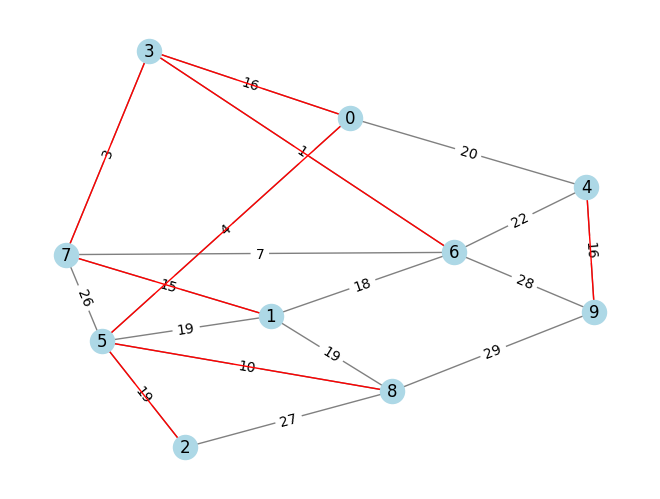

added edge (0, 4) with weight 20


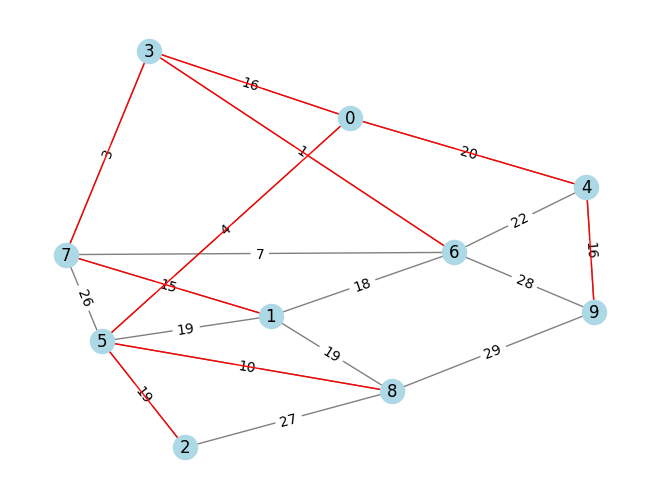

The minimum spanning tree has weight 104


In [20]:
mst = MSTKruskal(graph)
print("The minimum spanning tree has weight", mst.weight())

## Prim's Algorithm

Prim's algorithm builds up the spanning tree node by node, starting from an arbitrary node (we always use node 0). It always considers an edge of minimum weight among all edges incident to the current tree. If it connects a new node with the tree, it is added, otherwise it is discarded.

In [21]:
class LazyPrim:
    def __init__(self, graph):
        self.included_edges = []
        self.total_weight = 0

        # node-indexed list: True if node already in tree
        included_nodes = [False] * graph.number_of_nodes()
        candidates = []

        # include an arbitrary node (we use 0) in tree
        included_nodes[0] = True
        for node in graph.neighbors(0):
            weight = graph.get_edge_data(0, node)["weight"]
            heapq.heappush(candidates, (weight, 0, node))

        self.dump(candidates)

        while (candidates and
               len(self.included_edges) < graph.number_of_nodes() - 1):
            weight, v, w = heapq.heappop(candidates)

            if included_nodes[v] and included_nodes[w]:
                print("skipped edge", (v, w))
                continue
            if included_nodes[w]:
                v, w = w, v
            # v is in tree, w is not
            included_nodes[w] = True
            self.included_edges.append((v, w))
            print("added edge", (v, w), "with weight", weight)
            self.total_weight += weight
            for node in graph.neighbors(w):
                if not included_nodes[node]:
                    weight = graph.get_edge_data(w, node)["weight"]
                    heapq.heappush(candidates, (weight, w, node))
            self.dump(candidates)

                    
    def edges(self):
        for e in self.included_edges:
            yield e

    def weight(self):
        return self.total_weight
    
    def dump(self, candidates=None):
        nx.draw(graph, pos, with_labels=True, node_size=300, node_color='lightblue', edge_color="gray")
        edge_labels=dict([((u,v,),d['weight']) for u,v,d in graph.edges(data=True)])
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
        nx.draw_networkx_edges(graph, pos, edgelist=self.included_edges, edge_color="r")
        if candidates:
            edges = [(u,v) for (w, u, v) in candidates]
            nx.draw_networkx_edges(graph, pos, edgelist=edges, edge_color="b")
        plt.show()

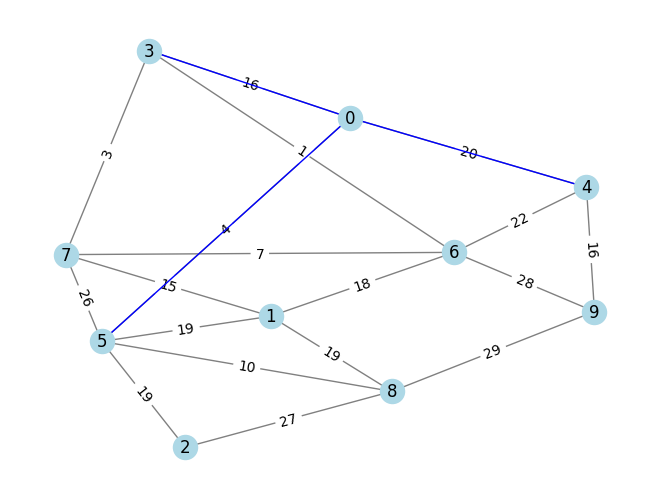

added edge (0, 5) with weight 4


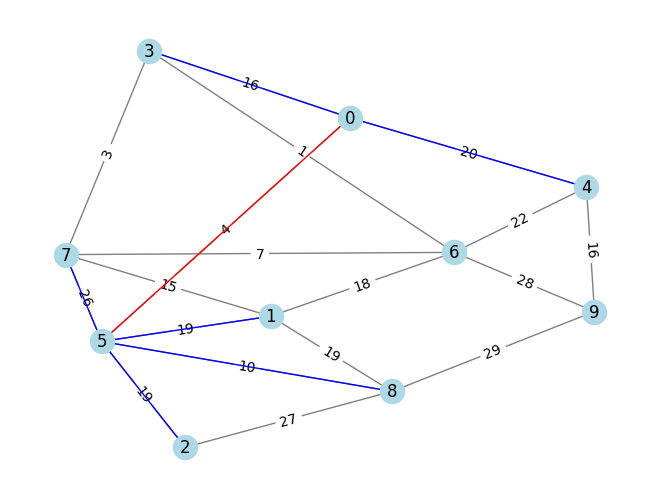

added edge (5, 8) with weight 10


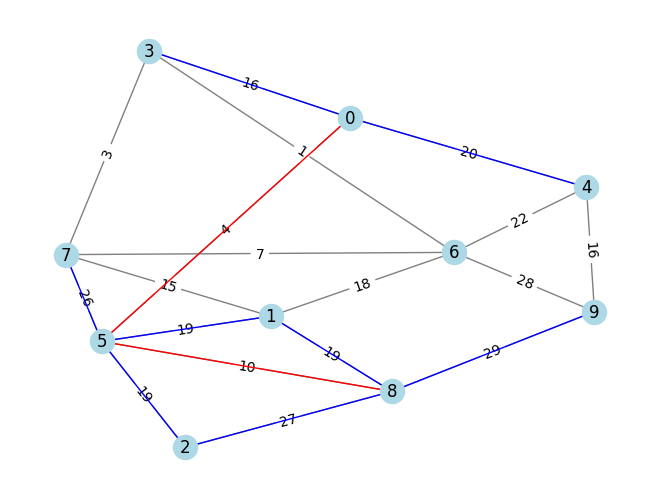

added edge (0, 3) with weight 16


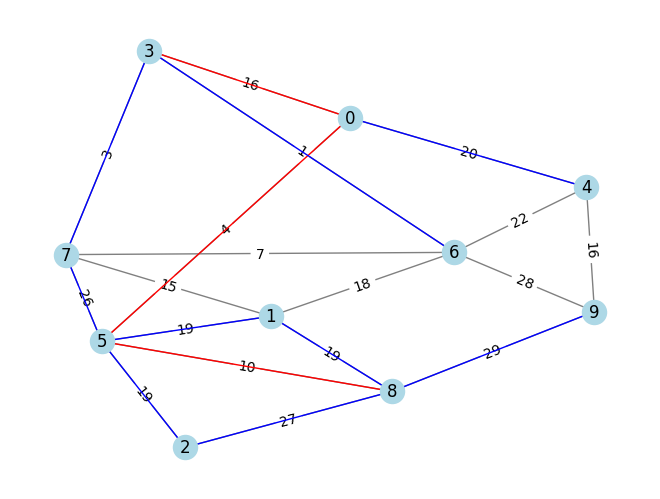

added edge (3, 6) with weight 1


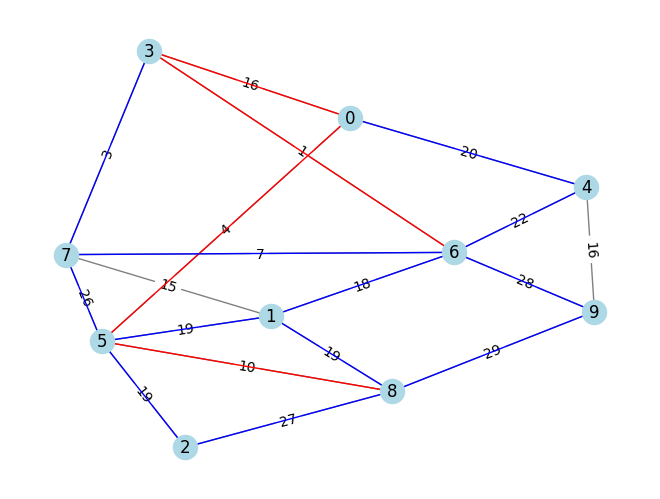

added edge (3, 7) with weight 3


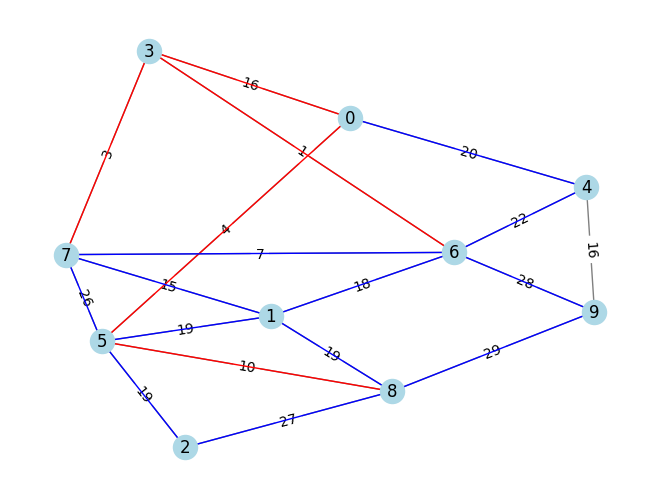

skipped edge (6, 7)
added edge (7, 1) with weight 15


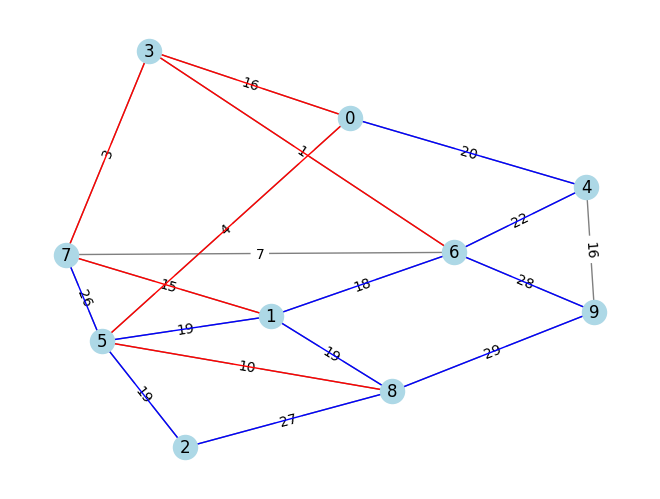

skipped edge (6, 1)
skipped edge (5, 1)
added edge (5, 2) with weight 19


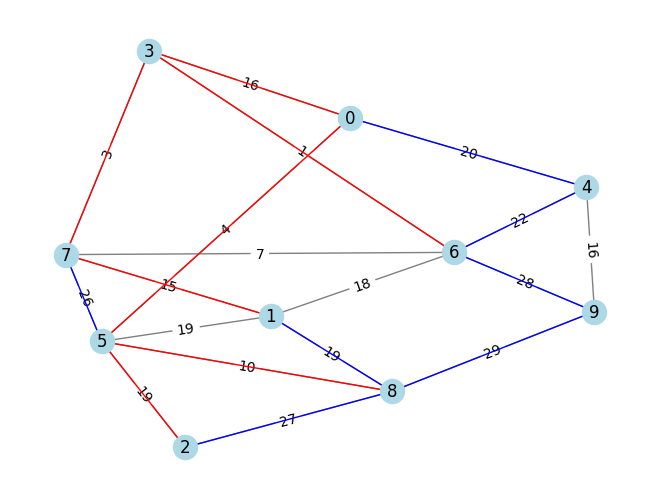

skipped edge (8, 1)
added edge (0, 4) with weight 20


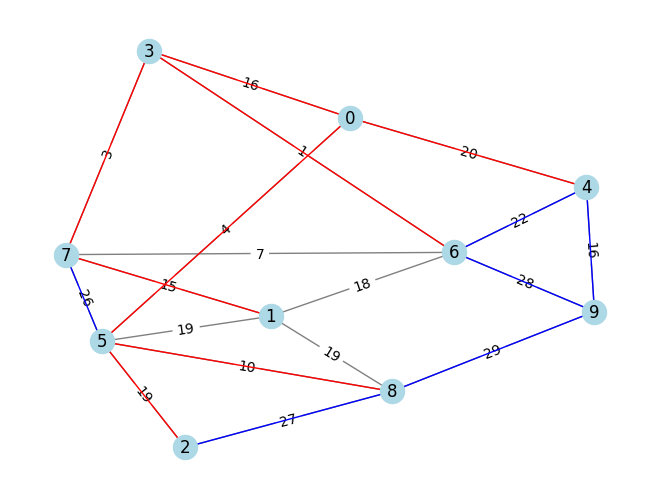

added edge (4, 9) with weight 16


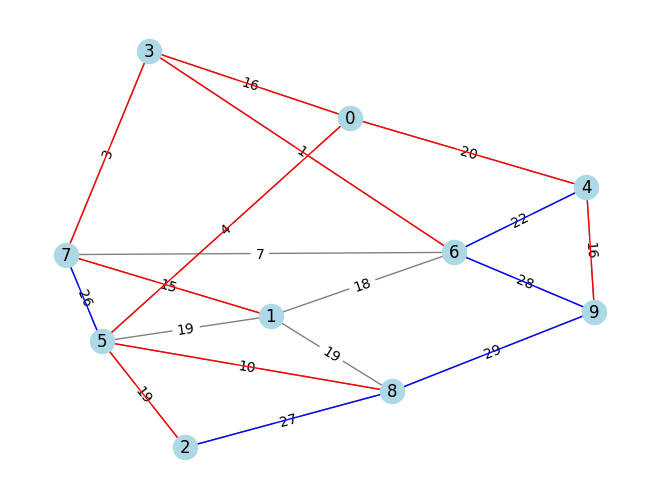

The minimum spanning tree has weight 104


In [22]:
mst = LazyPrim(graph)
print("The minimum spanning tree has weight", mst.weight())